Populating the interactive namespace from numpy and matplotlib


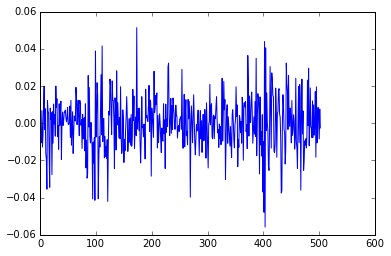

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import pandas.io.data as web
import matplotlib.pyplot as plt

ticker = 'MSFT'
stock_data = web.get_data_yahoo(ticker,'1/1/2010', '1/1/2012') 

price = pd.Series(stock_data['Adj Close']) 

logprice = price.apply(log)
logret = logprice.diff()
logret.dropna(inplace=True)

plot(logret)

In [2]:
from arch.unitroot import KPSS, ADF
kpss = KPSS(logret,lags=7)
print kpss.summary()
print '\n'

adf =  ADF(logret, lags=20, trend='ct', method='BIC')
print adf.summary()

    KPSS Stationarity Test Results   
Test Statistic                  0.087
P-value                         0.651
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


   Augmented Dickey-Fuller Results   
Test Statistic                 -5.579
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.98 (1%), -3.42 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


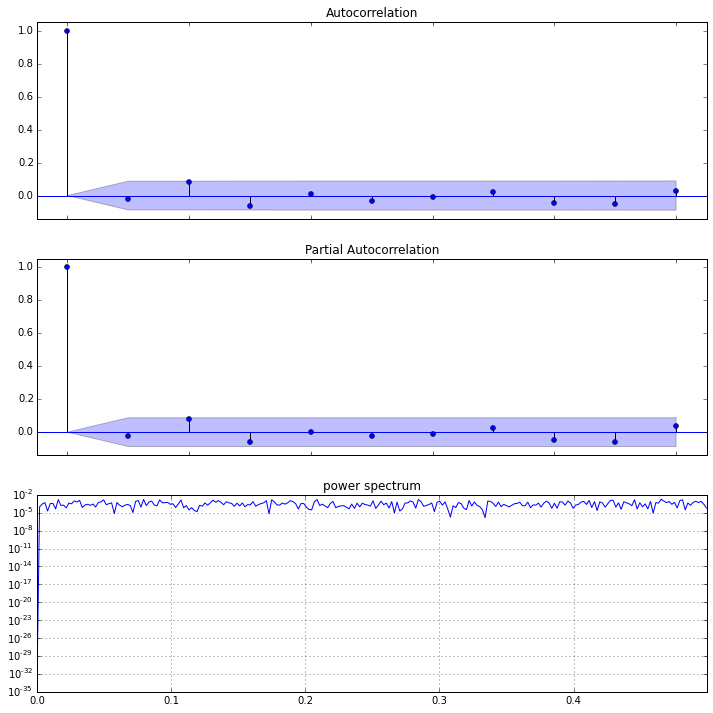

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.signal import periodogram as pgram

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(311)
fig1 = plot_acf(logret, ax=ax1, alpha=0.05, lags=10, use_vlines=True)
ax2 = fig.add_subplot(312)
fig2 = plot_pacf(logret, ax=ax2, alpha=0.05, lags=10, use_vlines=True)
ax3 = fig.add_subplot(313)
f, Pxx = pgram(logret)
fig3 = pd.Series(Pxx, index=f).plot(logy=True, ax=ax3, title='power spectrum')

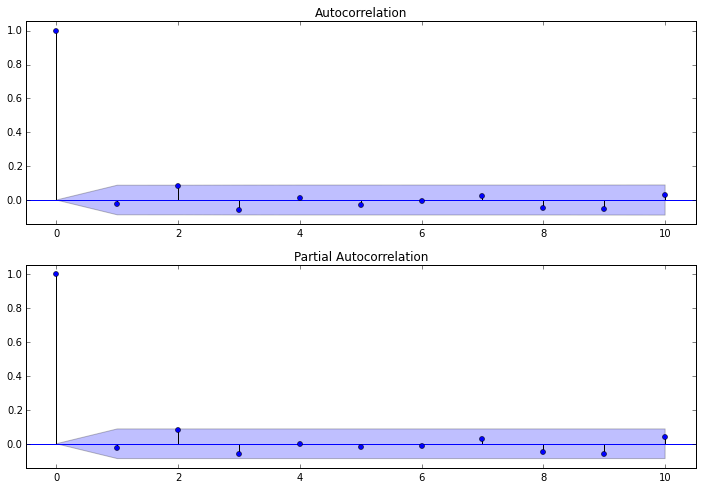

In [4]:
demean_r = logret - logret.mean()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig1 = plot_acf(demean_r, ax=ax1, alpha=0.05, lags=10, use_vlines=True)
ax2 = fig.add_subplot(212)
fig2 = plot_pacf(demean_r, ax=ax2, alpha=0.05, lags=10, use_vlines=True)

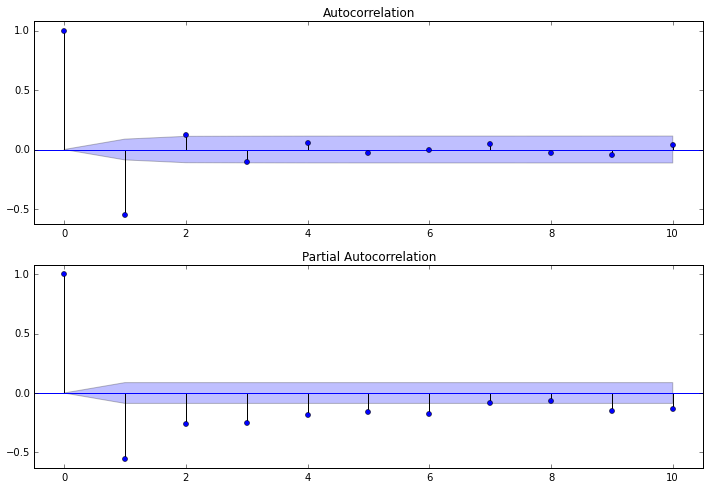

In [5]:
diff_demean_r = demean_r.diff()
diff_demean_r.dropna(inplace=True)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig1 = plot_acf(diff_demean_r, ax=ax1, alpha=0.05, lags=10, use_vlines=True)
ax2 = fig.add_subplot(212)
fig2 = plot_pacf(diff_demean_r, ax=ax2, alpha=0.05, lags=10, use_vlines=True)

In [34]:
import numpy

a = numpy.zeros((4,4))
a[3][0] = 1

#arma = sm.tsa.ARMA(demean_r, (3,3)).fit()

numpy.argmax(a)

12

##Select TS model by BIC/LLF

In [40]:
import statsmodels.api as sm
import numpy

#define the maximum p & q for the trials
p = 4
q = 4

#initalize two pXq matrix bic and llf to store the bic and llf value 
bic = numpy.zeros((p,q))
llf = numpy.zeros((p,q))

#fill in the bic and llf matrix
for i in range(p):
    for j in range(q):
        try:
            arma = sm.tsa.ARMA(demean_r, (i,j)).fit()
            bic[i][j] = arma.bic
            llf[i][j] = arma.llf
            #print 'ARMA(%f,%f) is stationary' %(i,j)
        except ValueError:
            pass
            #print 'ARMA(%f,%f) is not stationary' %(i,j)

#Reset value for bic[0][0] and llf[0][0], since ARMA(0,0) does not make sence
bic[0][0] = 0
llf[0][0] = 0
#print bic
#print llf

#print out the minimum BIC and maximum LLF and the coresponding model
min_bic = numpy.min(bic)
bic_i = numpy.argmin(bic)/q
bic_j = numpy.argmin(bic) - bic_i*q
print 'The minimum BIC is for ARMA(%d,%d), LLF: %f BIC: %f' % (bic_i,bic_j,llf[bic_i][bic_j],min_bic)

max_llf = numpy.max(llf)
llf_i = numpy.argmax(llf)/q
llf_j = numpy.argmax(llf) - llf_i*q
print 'The maximum LLF is for ARMA(%d,%d), LLF: %f BIC: %f' % (llf_i,llf_j,max_llf,bic[llf_i][llf_j])

/Users/cong/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/cong/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The minimum BIC is for ARMA(1,0), LLF: 1422.897439 BIC: -2827.133108
The maximum LLF is for ARMA(3,3), LLF: 1427.562297 BIC: -2805.359873


In [44]:
import statsmodels.api as sm

arima_mod011 = sm.tsa.ARIMA(demean_r, (0,1,1)).fit()
print arma_mod11.params
print 'fit AIC: %f' %arima_mod011.aic
print 'fit BIC: %f' %arima_mod011.bic
print 'fit HQIC: %f' %arima_mod011.hqic
print 'fit LLF: %f' %arima_mod011.llf


const             -0.000000
ar.L1.Adj Close   -0.228559
ma.L1.Adj Close    0.137047
dtype: float64
fit AIC: -3919.581281
fit BIC: -3905.705104
fit HQIC: -3914.235823
fit LLF: 1962.790640


ARMA(1,1) fit result is:

\begin{align}
X_t＝ －0.228559 X_{t-1} + Z_t + 0.137047 Z_{t-1}
\end{align}


## Redisuals (from a normal distribution?)

  - normaltest and shapirp test shows residuals not from normal distribution.

In [35]:
from scipy.stats import normaltest, shapiro
print 'normaltest: '
print normaltest(resid)
print 'shapiro test: '
print shapiro(resid)

normaltest: 
(104.87397929245668, 1.6861831652795248e-23)
shapiro test: 
(0.9419151544570923, 1.3282170121172994e-16)


In [38]:
from statsmodels.stats.stattools import durbin_watson
print durbin_watson(resid)

2.00066435296


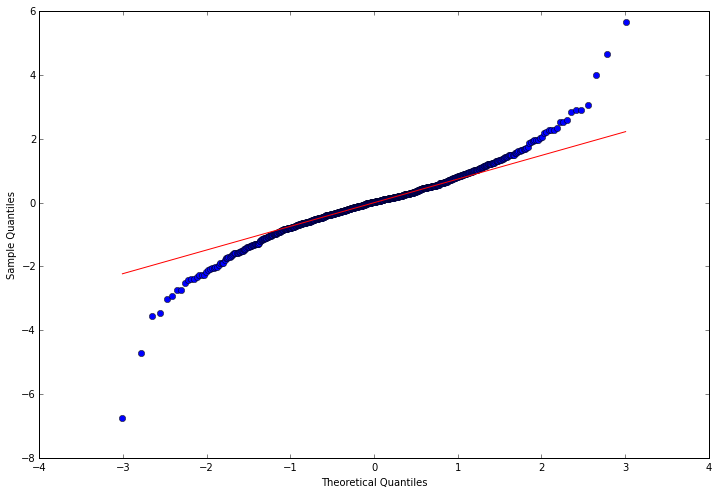

In [39]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

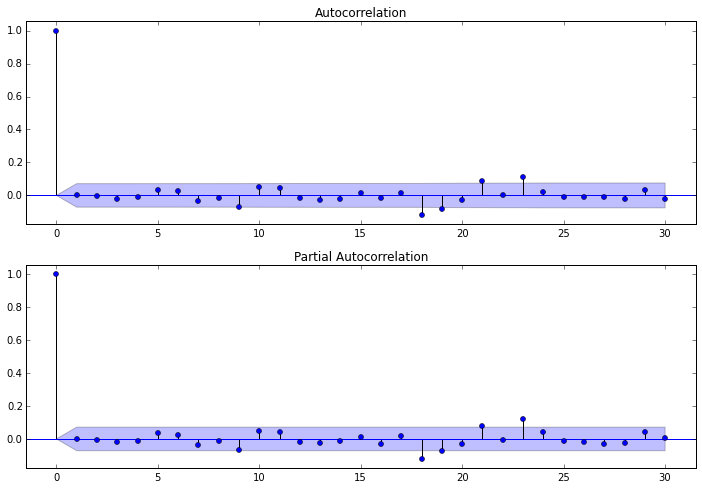

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid, lags=30, ax=ax2)

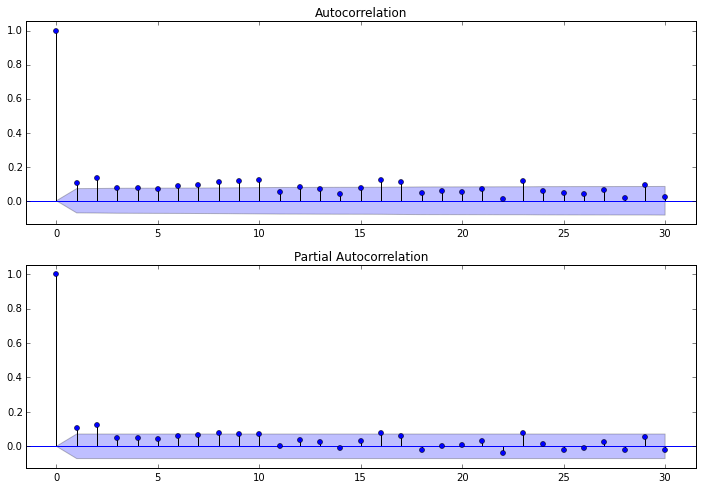

In [80]:
resid2 = resid**2
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid2, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid2, lags=30, ax=ax2)


## ARMA(1,1)+GARCH(1,1)

In [88]:
from arch import arch_model
am = arch_model(resid, p=2, q=2) 
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: -2054.59819239
Iteration:      2,   Func. Count:     23,   Neg. LLF: -2054.62616405
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2054.62616572
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2054.63
Distribution:                  Normal   AIC:                          -4097.25
Method:            Maximum Likelihood   BIC:                          -4069.49
                                        No. Observations:                  755
Date:                Mon, Mar 09 2015   Df Residuals:                      749
Time:           

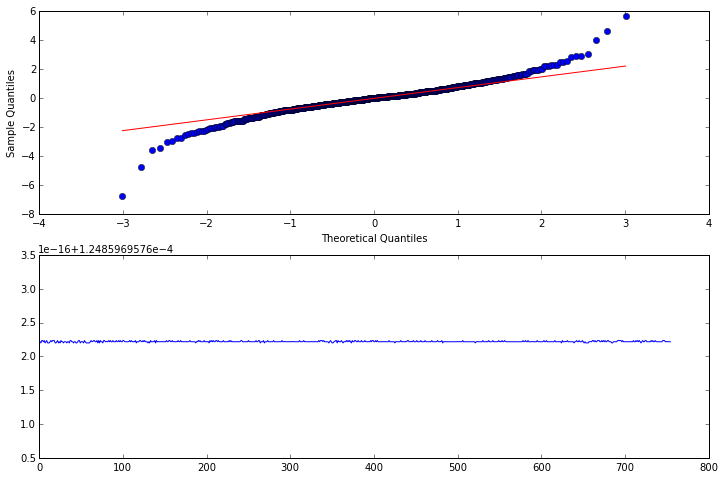

In [97]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig1 = qqplot(res.resid, line='q', ax=ax1, fit=True)
#fig2 = plt.hist(res.resid, bins=20)
#fig3 = res.resid.plot()
plt.plot(resid - res.resid)


In [92]:
from scipy.stats import normaltest, shapiro
print 'normaltest: '
print normaltest(res.resid)
print 'shapiro test: '
print shapiro(res.resid)

normaltest: 
(104.87397929245665, 1.6861831652795489e-23)
shapiro test: 
(0.941914975643158, 1.3281223826552233e-16)
